In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

In [5]:
# -----------------------------------------------------------------------------
# HASEL Functions
# -----------------------------------------------------------------------------

def hasel_area(Lp, alpha_0):
    '''
    HASEL actuators maintain a constant cross-sectional because the hydraulic
    fluid is incrompressible. Therefore this area is constant for a given
    initial length and zipping angle
    
    Arguments:
    -> Lp: initial length of outer layers
    -> alpha_0: initial zipping angle (in radians)
    Returns:
    -> The constant area of the HASEL actuator (mm^2)
    '''
    return (Lp**2)*(alpha_0 - np.sin(2*alpha_0)/2) / (2*alpha_0**2)


def hasel_force(alpha, w, t, eps_r, V):
    '''
    Calculates the output force of an actuator given the current zipping angle
    and a number of characteristics of the actuator

    Arguments:
    -> alpha: the current zipping angle of the actuator (radians)
    -> w: width of the actuator (m)
    -> t: thickness of pouch material (m)
    -> eps_r: relative permittivity of the pouch material (no units)
    -> V: voltage applied to the actuator (V)
    Returns:
    -> Force output (N)
    '''
    eps_0 = 8.8541878128e-12 # F m^-1
    c = (w/(4*t))*eps_r*eps_0*V**2
    F = c*(np.cos(alpha)/(1-np.cos(alpha)))
    return F

def angle_to_strain(alpha, alpha_0, A, Lp):
    '''
    Converts a particular zipping angle for a pouch to the strain value where
    that zipping angle occurs

    Arguments:
    -> alpha: the current zipping angle of the actuator
    -> alpha_0: the initial zipping angle of the actuator
    -> A: the cross-sectional area of the actuator (mm^2)
    -> Lp: the length of the pouch
    Returns:
    -> The strain (between 0 and 1) at which the angle alpha occurs
    '''
    c1 = (alpha_0/math.sin(alpha_0))
    c2 = (math.sqrt(2*A)/Lp)
    num = np.sin(alpha)-alpha
    den = np.sqrt(alpha - np.sin(alpha)*np.cos(alpha))
    strain = 1 - c1 * (1 +  c2 * (num/den))
    return strain

def le_to_strain(le, Lp, alpha_0):
    '''
    Calculates the strain of an actuator given the zipped electrode length

    Arguments:
    -> le: the length of the zipped electrode (le)
    -> Lp: the length of the actuator (m)
    -> alpha_0: the initial zipping angle (rad)
    Returns:
    -> The corresponding strain ([0, 1])
    '''
    A = hasel_area(Lp, alpha_0)
    h = Lp*np.sin(alpha_0)/alpha_0

    alpha = []
    for length in le:
        alpha.append(le_to_angle(length, Lp, A, alpha_0))
    alpha = np.array(alpha)

    x = h - ((Lp-le)*np.sin(alpha)/alpha + le)

    return x/h

def le_to_angle(le, Lp, A, alpha_0, maxiter=50):
    '''
    Calculates the zipping angle of an actuator given the zipped electrode length

    Arguments:
    -> le: the length of the zipped electrode (le)
    -> Lp: the length of the actuator (m)
    -> A: the cross-sectional area of the pouch (m^2)
    -> alpha_0: the initial zipping angle (rad)
    -> maxiter: the maximum number of iterations for Newton's method 
    Returns:
    -> The corresponding zipping angle alpha (rad)
    '''
    def f(alpha, Lp, A):
        return Lp - np.sqrt(2*A*alpha**2/(alpha - np.sin(alpha)*np.cos(alpha))) - le
    def df(a, Lp, A):
        t1 = 2*A*a/(a-np.sin(a)*np.cos(a))
        t2 = A*a**2*(np.sin(a)**2-np.cos(a)**2+1)/(a-np.sin(a)*np.cos(a))**2
        t3 = np.sqrt(A*a**2/(a-np.sin(a)*np.cos(a)))

        return (t2-t1)/(np.sqrt(2)*t3)

    guess = alpha_0/2
    alpha = optimize.newton(f, fprime=df, x0=guess, args=(Lp, A), maxiter=maxiter)
    return alpha

def coverage_to_angle(coverage):
    '''
    The initial zipping angle of the actuator can be calculated from the
    electrode coverage alone. The electrode coverage is the ratio of the
    electrode length (le) to the initial pouch length (Lp).
    
    Arguments:
    -> coverage: a value between 0 and 1 that corresponds to the ratio between
                 the electrode length and initial pouch length
    Returns:
    -> The corresponding initial zipping angle in radians
    '''
    return (12/(4*math.pi))*(1-coverage)**2

In [6]:
# -----------------------------------------------------------------------------
# Plotting
# -----------------------------------------------------------------------------

def plot_stress_strain_ideal(V, Lp, w, t, eps_r, alpha_0, x_lim=20, y_lim=20):
    '''
    Creates a plot of an ideal pouch

    Arguments:
    -> V: voltage applied to the actuator (V)
    -> Lp: the length of the actuator (m)
    -> w: width of the actuator (m)
    -> t: thickness of pouch material (m)
    -> eps_r: relative permittivity of the pouch material
    '''

    # Calculate stress
    alpha = np.linspace(alpha_0, math.pi/2, num=100)
    stress = hasel_force(alpha, w, t, eps_r, V)

    # Calculate strain
    A = hasel_area(Lp, alpha_0)
    strain = angle_to_strain(alpha, alpha_0, A, Lp)

    plot_stress_strain(stress, strain, x_lim=x_lim, y_lim=y_lim)

def plot_stress_strain(stress, strain, style='', x_lim=20, y_lim=20):
    '''
    Creates a stress-strain plot

    Arguments:
    -> stress: a list of the force values (N)
    -> strain: a list of the strain values ([0, 1])
    '''

    plt.plot(strain*100, stress, style, linewidth=0.75)
    plt.xlabel('Strain (%)')
    plt.ylabel('Force (N)')
    plt.xlim((0, x_lim))
    plt.ylim((0, y_lim))
    plt.grid(visible=True, alpha=0.35)

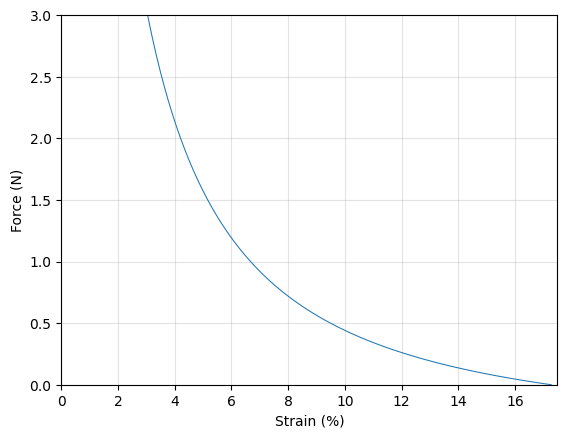

In [7]:
#-------------------------------------------------------------------------------
# Main
#-------------------------------------------------------------------------------
alpha_0 = coverage_to_angle(0.5)
x_lim = 17.5
y_lim = 3

V = 8e3
Lp = 30e-3
w = 60e-3
t = 28e-6
eps_r = 2.2
plot_stress_strain_ideal(V, Lp, w, t, eps_r, alpha_0, x_lim=x_lim, y_lim=y_lim)

plt.show()